In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
from joblib import Parallel,delayed

from scipy import signal
from scipy.signal import resample,hilbert
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [67]:
# set data paths
dataset_path = 'partial_signal_dataset100000.npy'
envelopes_path = 'envelopes100k.npy'
label_csv_path = 'partial_signal_df100000.csv'

In [44]:
class ClassificationLSTM:

    def __init__(self,envelopes_path,label_csv_path,target):
        self.envelopes_path = envelopes_path
        self.label_csv_path = label_csv_path
        self.target = target
        self.envelopes = []
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.model = []
        self.ypred = []
        self.cm = []
        self.history = []
        self.epochs = []
        self.accuracy = []
        self.precision = []
        self.recall = []
        
        self.envelopes = np.load(self.envelopes_path,allow_pickle=True)
        self.label_csv = pd.read_csv(self.label_csv_path)
        self.labels = self.label_csv[target]
        self.labels = np.array(self.labels.map(lambda x: 1 if x == 'earthquake_local' else 0))
        
        
    def train_test_split(self, test_size,random_state):
    
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.envelopes, self.labels,random_state = random_state,test_size=test_size) # train test split
        self.X_train = np.reshape(self.X_train, (np.array(self.X_train).shape[0], 1, np.array(self.X_train).shape[1]))
        self.X_test = np.reshape(self.X_test, (np.array(self.X_test).shape[0], 1, np.array(self.X_test).shape[1]))
        self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape
        
    def LSTM_fit(self,epochs,metric,batch_size):
        
        self.epochs = epochs
        # set callbacks to save model at each epoch
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'./saved_models/LSTM_100000_dataset_classification_epochs{epochs}_{format(datetime.now().strftime("%Y%m%d%h%m%s"))}',
                save_freq='epoch')
        ]

        # model design
        model = keras.Sequential()
        model.add(keras.layers.SimpleRNN(64, input_shape=(1,self.X_train.shape[2]), return_sequences=True))
        model.add(keras.layers.LSTM(64, input_shape=(1,self.X_train.shape[2]), return_sequences=True))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.LSTM(32, return_sequences=False))
        model.add(keras.layers.Dense(16, activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        opt = keras.optimizers.Adam(learning_rate=4e-5)
        model.compile(optimizer=opt,
                      loss='binary_crossentropy', metrics=metric)
 
        # fit and predict
        self.model = model
        self.history = model.fit(self.X_train, self.y_train, batch_size=batch_size, epochs=self.epochs,callbacks=callbacks,validation_split=0.2)
        
        # plot train/test accuracy history
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['accuracy'])
        ax.plot(self.history.history['val_accuracy'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_accuracy.png')
        plt.show()
        
                

    def LSTM_evaluate(self):
        
        self.y_pred = self.model.predict(self.X_test) # get predictions
        
        print('Evaluating model on test dataset')

        # evaluate model
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f'Test data accuracy: {test_acc}')

        predicted_classes = self.model.predict_classes(self.X_test)
        self.accuracy = accuracy_score(self.y_test,predicted_classes)
        self.precision = precision_score(self.y_test,predicted_classes)
        self.recall = recall_score(self.y_test,predicted_classes)
        print(f'The accuracy of the model is {self.accuracy}, the precision is {self.precision}, and the recall is {self.recall}')
        
        # save model
        saved_model_path = f'./saved_models/LSTM_classification_acc{self.accuracy}_prec{self.precision}_rec{self.recall}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}' # _%H%M%S
        # Save entire model to a HDF5 file
        self.model.save(saved_model_path)
        
        # confusion matrix
        self.cm = confusion_matrix(self.y_test,predicted_classes)
        
        # plot confusion matrix
        plt.style.use('default')
        disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=['not earthquake','earthquake'])
        disp.plot(cmap='Blues', values_format='')
        plt.title(f'Classification LSTM Results ({self.epochs} epochs)')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()



/Users/kaelynnrose/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Epoch 1/100
938/938 [==============================] - 6s 4ms/step - loss: 0.5895 - accuracy: 0.7098 - val_loss: 0.3405 - val_accuracy: 0.8848


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 2/100
938/938 [==============================] - 2s 3ms/step - loss: 0.2934 - accuracy: 0.8976 - val_loss: 0.2204 - val_accuracy: 0.9269


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2048 - accuracy: 0.9359 - val_loss: 0.1799 - val_accuracy: 0.9455


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 4/100
938/938 [==============================] - 2s 2ms/step - loss: 0.1622 - accuracy: 0.9512 - val_loss: 0.1547 - val_accuracy: 0.9509


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 5/100
938/938 [==============================] - 2s 3ms/step - loss: 0.1411 - accuracy: 0.9564 - val_loss: 0.1371 - val_accuracy: 0.9568


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 6/100
938/938 [==============================] - 2s 3ms/step - loss: 0.1273 - accuracy: 0.9599 - val_loss: 0.1248 - val_accuracy: 0.9585


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 7/100
938/938 [==============================] - 2s 2ms/step - loss: 0.1152 - accuracy: 0.9637 - val_loss: 0.1173 - val_accuracy: 0.9603


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 8/100
938/938 [==============================] - 2s 2ms/step - loss: 0.1045 - accuracy: 0.9666 - val_loss: 0.1104 - val_accuracy: 0.9625


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 9/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0997 - accuracy: 0.9680 - val_loss: 0.1064 - val_accuracy: 0.9632


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 10/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0967 - accuracy: 0.9677 - val_loss: 0.1032 - val_accuracy: 0.9637


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 11/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0884 - accuracy: 0.9697 - val_loss: 0.1015 - val_accuracy: 0.9645


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 12/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0869 - accuracy: 0.9706 - val_loss: 0.0962 - val_accuracy: 0.9663


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 13/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0864 - accuracy: 0.9716 - val_loss: 0.0965 - val_accuracy: 0.9667


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 14/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0853 - accuracy: 0.9717 - val_loss: 0.0963 - val_accuracy: 0.9655


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 15/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0806 - accuracy: 0.9733 - val_loss: 0.0927 - val_accuracy: 0.9677


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 16/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0809 - accuracy: 0.9728 - val_loss: 0.0917 - val_accuracy: 0.9680


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 17/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0822 - accuracy: 0.9721 - val_loss: 0.0898 - val_accuracy: 0.9693


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 18/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9738 - val_loss: 0.0879 - val_accuracy: 0.9697


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 19/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0708 - accuracy: 0.9761 - val_loss: 0.0878 - val_accuracy: 0.9697


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 20/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9757 - val_loss: 0.0891 - val_accuracy: 0.9689


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 21/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0703 - accuracy: 0.9770 - val_loss: 0.0868 - val_accuracy: 0.9695


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 22/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0735 - accuracy: 0.9755 - val_loss: 0.0882 - val_accuracy: 0.9702


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 23/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9749 - val_loss: 0.0867 - val_accuracy: 0.9698


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 24/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0705 - accuracy: 0.9757 - val_loss: 0.0862 - val_accuracy: 0.9705


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 25/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0680 - accuracy: 0.9769 - val_loss: 0.0862 - val_accuracy: 0.9701


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 26/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0675 - accuracy: 0.9777 - val_loss: 0.0857 - val_accuracy: 0.9709


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 27/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0691 - accuracy: 0.9762 - val_loss: 0.0840 - val_accuracy: 0.9706


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 28/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9783 - val_loss: 0.0852 - val_accuracy: 0.9709


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 29/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0639 - accuracy: 0.9786 - val_loss: 0.0827 - val_accuracy: 0.9721


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 30/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9787 - val_loss: 0.0832 - val_accuracy: 0.9715


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 31/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9785 - val_loss: 0.0839 - val_accuracy: 0.9716


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 32/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0654 - accuracy: 0.9780 - val_loss: 0.0829 - val_accuracy: 0.9719


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 33/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0622 - accuracy: 0.9779 - val_loss: 0.0831 - val_accuracy: 0.9721


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 34/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9776 - val_loss: 0.0825 - val_accuracy: 0.9725


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 35/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0603 - accuracy: 0.9798 - val_loss: 0.0838 - val_accuracy: 0.9717


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 36/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0601 - accuracy: 0.9793 - val_loss: 0.0831 - val_accuracy: 0.9715


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 37/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0580 - accuracy: 0.9801 - val_loss: 0.0807 - val_accuracy: 0.9725


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 38/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9793 - val_loss: 0.0835 - val_accuracy: 0.9709


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 39/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0554 - accuracy: 0.9808 - val_loss: 0.0847 - val_accuracy: 0.9711


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 40/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9803 - val_loss: 0.0828 - val_accuracy: 0.9719


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 41/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0529 - accuracy: 0.9825 - val_loss: 0.0827 - val_accuracy: 0.9721


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 42/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0572 - accuracy: 0.9804 - val_loss: 0.0852 - val_accuracy: 0.9704


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 43/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0570 - accuracy: 0.9806 - val_loss: 0.0834 - val_accuracy: 0.9713


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 44/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0564 - accuracy: 0.9813 - val_loss: 0.0822 - val_accuracy: 0.9720


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 45/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0545 - accuracy: 0.9816 - val_loss: 0.0822 - val_accuracy: 0.9726


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 46/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0551 - accuracy: 0.9806 - val_loss: 0.0832 - val_accuracy: 0.9719


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 47/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0564 - accuracy: 0.9806 - val_loss: 0.0814 - val_accuracy: 0.9725


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 48/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0539 - accuracy: 0.9824 - val_loss: 0.0798 - val_accuracy: 0.9736


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 49/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0538 - accuracy: 0.9819 - val_loss: 0.0793 - val_accuracy: 0.9739


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 50/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0542 - accuracy: 0.9813 - val_loss: 0.0812 - val_accuracy: 0.9734


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 51/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0545 - accuracy: 0.9814 - val_loss: 0.0812 - val_accuracy: 0.9727


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 52/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0537 - accuracy: 0.9820 - val_loss: 0.0826 - val_accuracy: 0.9730


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 53/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0554 - accuracy: 0.9810 - val_loss: 0.0836 - val_accuracy: 0.9724


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 54/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0549 - accuracy: 0.9816 - val_loss: 0.0838 - val_accuracy: 0.9723


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 55/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0516 - accuracy: 0.9822 - val_loss: 0.0840 - val_accuracy: 0.9724


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 56/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0509 - accuracy: 0.9822 - val_loss: 0.0834 - val_accuracy: 0.9727


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 57/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0496 - accuracy: 0.9833 - val_loss: 0.0830 - val_accuracy: 0.9713


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 58/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0492 - accuracy: 0.9832 - val_loss: 0.0836 - val_accuracy: 0.9723


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 59/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0518 - accuracy: 0.9821 - val_loss: 0.0824 - val_accuracy: 0.9728


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 60/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0496 - accuracy: 0.9831 - val_loss: 0.0819 - val_accuracy: 0.9732


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 61/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0500 - accuracy: 0.9832 - val_loss: 0.0820 - val_accuracy: 0.9727


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 62/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0500 - accuracy: 0.9832 - val_loss: 0.0819 - val_accuracy: 0.9727


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 63/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0492 - accuracy: 0.9834 - val_loss: 0.0826 - val_accuracy: 0.9735


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 64/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0512 - accuracy: 0.9831 - val_loss: 0.0814 - val_accuracy: 0.9729


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 65/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0474 - accuracy: 0.9833 - val_loss: 0.0822 - val_accuracy: 0.9727


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 66/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0506 - accuracy: 0.9822 - val_loss: 0.0824 - val_accuracy: 0.9735


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 67/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0472 - accuracy: 0.9842 - val_loss: 0.0826 - val_accuracy: 0.9728


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 68/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0458 - accuracy: 0.9854 - val_loss: 0.0816 - val_accuracy: 0.9741


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 69/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0481 - accuracy: 0.9836 - val_loss: 0.0810 - val_accuracy: 0.9743


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 70/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0465 - accuracy: 0.9840 - val_loss: 0.0818 - val_accuracy: 0.9741


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 71/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0441 - accuracy: 0.9845 - val_loss: 0.0805 - val_accuracy: 0.9747


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 72/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0448 - accuracy: 0.9847 - val_loss: 0.0836 - val_accuracy: 0.9737


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 73/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0464 - accuracy: 0.9850 - val_loss: 0.0828 - val_accuracy: 0.9730


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 74/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0445 - accuracy: 0.9850 - val_loss: 0.0827 - val_accuracy: 0.9737


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 75/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0470 - accuracy: 0.9839 - val_loss: 0.0833 - val_accuracy: 0.9738


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 76/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0461 - accuracy: 0.9848 - val_loss: 0.0847 - val_accuracy: 0.9735


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 77/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0449 - accuracy: 0.9851 - val_loss: 0.0831 - val_accuracy: 0.9737


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 78/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0472 - accuracy: 0.9839 - val_loss: 0.0829 - val_accuracy: 0.9735


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 79/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0443 - accuracy: 0.9846 - val_loss: 0.0814 - val_accuracy: 0.9735


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 80/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0432 - accuracy: 0.9848 - val_loss: 0.0831 - val_accuracy: 0.9728


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 81/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0474 - accuracy: 0.9837 - val_loss: 0.0819 - val_accuracy: 0.9732


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 82/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0459 - accuracy: 0.9841 - val_loss: 0.0809 - val_accuracy: 0.9745


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 83/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0439 - accuracy: 0.9845 - val_loss: 0.0831 - val_accuracy: 0.9737


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 84/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0444 - accuracy: 0.9847 - val_loss: 0.0832 - val_accuracy: 0.9738


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 85/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0440 - accuracy: 0.9849 - val_loss: 0.0824 - val_accuracy: 0.9733


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 86/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0453 - accuracy: 0.9841 - val_loss: 0.0817 - val_accuracy: 0.9741


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 87/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0412 - accuracy: 0.9858 - val_loss: 0.0813 - val_accuracy: 0.9741


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 88/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0419 - accuracy: 0.9857 - val_loss: 0.0824 - val_accuracy: 0.9741


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 89/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0426 - accuracy: 0.9858 - val_loss: 0.0828 - val_accuracy: 0.9740


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 90/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0434 - accuracy: 0.9858 - val_loss: 0.0846 - val_accuracy: 0.9731


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 91/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.0843 - val_accuracy: 0.9733


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 92/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0422 - accuracy: 0.9858 - val_loss: 0.0875 - val_accuracy: 0.9722


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 93/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0429 - accuracy: 0.9852 - val_loss: 0.0857 - val_accuracy: 0.9728


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 94/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 0.0855 - val_accuracy: 0.9724


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 95/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0429 - accuracy: 0.9858 - val_loss: 0.0853 - val_accuracy: 0.9732


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 96/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0401 - accuracy: 0.9861 - val_loss: 0.0852 - val_accuracy: 0.9730


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 97/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0398 - accuracy: 0.9870 - val_loss: 0.0871 - val_accuracy: 0.9731


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 98/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0414 - accuracy: 0.9860 - val_loss: 0.0853 - val_accuracy: 0.9736


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 99/100
938/938 [==============================] - 2s 3ms/step - loss: 0.0401 - accuracy: 0.9862 - val_loss: 0.0872 - val_accuracy: 0.9729


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


Epoch 100/100
938/938 [==============================] - 2s 2ms/step - loss: 0.0407 - accuracy: 0.9863 - val_loss: 0.0849 - val_accuracy: 0.9737


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_classification_epochs100_20210424Apr041619293381/assets


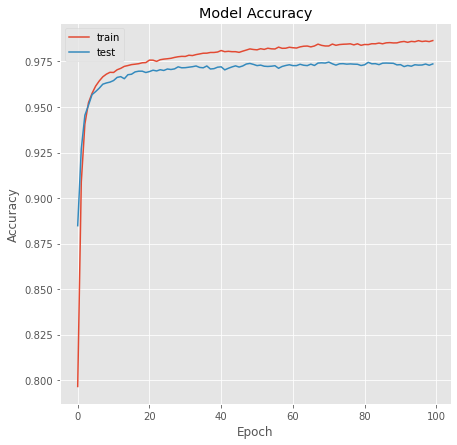

Evaluating model on test dataset
782/782 [==============================] - 1s 842us/step - loss: 0.0772 - accuracy: 0.9741
Test data accuracy: 0.974120020866394


/Users/kaelynnrose/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The accuracy of the model is 0.97412, the precision is 0.9774326297623789, and the recall is 0.979578261158784


INFO:tensorflow:Assets written to: ./saved_models/LSTM_classification_acc0.97412_prec0.9774326297623789_rec0.979578261158784_epochs100_20210424/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_classification_acc0.97412_prec0.9774326297623789_rec0.979578261158784_epochs100_20210424/assets


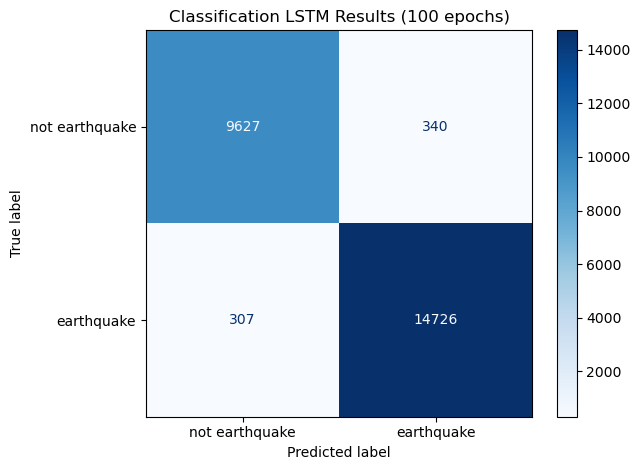

In [4]:
# use ClassificationLSTM
# predict earthquake or noise
model_c2 = ClassificationLSTM(envelopes_path,label_csv_path,'trace_category')
model_c2.train_test_split(test_size=0.25,random_state=44)
model_c2.LSTM_fit(epochs=100,metric='accuracy',batch_size=64)
model_c2.LSTM_evaluate()

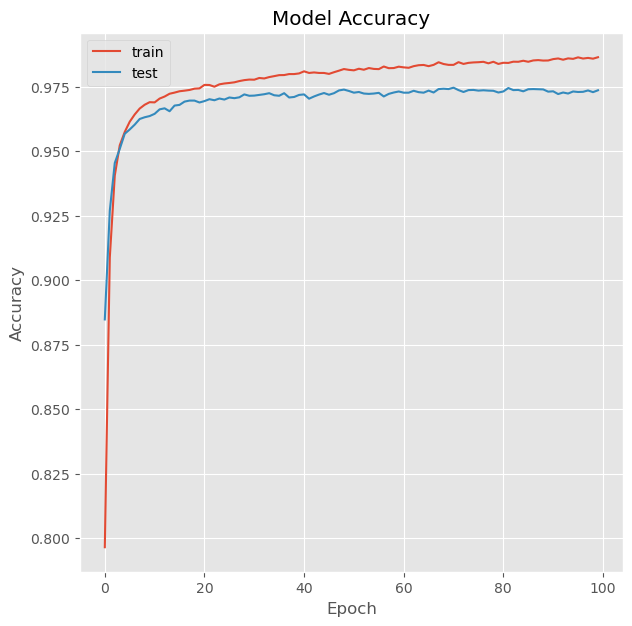

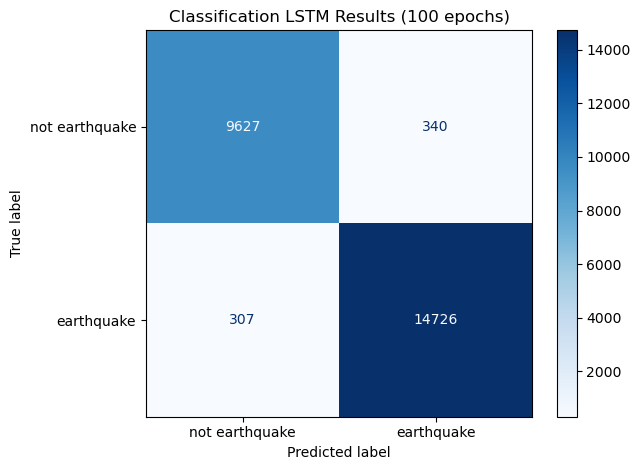

The accuracy of the baseline model for earthquake vs. noise prediction is is 0.52164, the precision is 0.5996003996003996, and the recall is 0.5988824585910996

 The accuracy of the classification model for earthquake vs. noise prediction is 0.97412, the precision is 0.9774326297623789, and the recall is 0.979578261158784


In [61]:
# plot train/test accuracy history
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(model_c2.history.history['accuracy'])
ax.plot(model_c2.history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train','test'])
plt.savefig('model_accuracy.png')
plt.show()

# plot confusion matrix
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=model_c2.cm, display_labels=['not earthquake','earthquake'])
disp.plot(cmap='Blues', values_format='')
plt.title(f'Classification LSTM Results ({model_c2.epochs} epochs)')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# baseline classifier for this model

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(model_c2.X_train, model_c2.y_train)
predictions = dummy_clf.predict(model_c2.X_test)
acc = dummy_clf.score(model_c2.X_test, model_c2.y_test)
prec = precision_score(model_c2.y_test,predictions)
rec = recall_score(model_c2.y_test,predictions)
print(f'The accuracy of the baseline model for earthquake vs. noise prediction is is {acc}, the precision is {prec}, and the recall is {rec}')

# accuracy, precision, recall
tn, fp, fn, tp = model_c2.cm.ravel()
accuracy = (tn + tp)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(f'\n The accuracy of the classification model for earthquake vs. noise prediction is {accuracy}, the precision is {precision}, and the recall is {recall}')


In [71]:
class RegressionLSTM:

    def __init__(self,envelopes_path,label_csv_path,target):
        self.envelopes_path = envelopes_path
        self.label_csv_path = label_csv_path
        self.target = target
        self.envelopes = []
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.model = []
        self.ypred = []
        self.cm = []
        self.history = []
        self.epochs = []
        self.test_loss = []
        
        self.envelopes = np.load(self.envelopes_path,allow_pickle=True)
        self.label_csv = pd.read_csv(self.label_csv_path)
        self.labels = self.label_csv[target]
        
        eq_envelopes = np.array(self.envelopes)[self.label_csv['trace_category'] == 'earthquake_local']
        print(len(eq_envelopes))
        eq_labels = self.label_csv[self.target][self.label_csv['trace_category'] == 'earthquake_local']
        print(len(eq_labels))
        
        self.envelopes = eq_envelopes
        self.labels = eq_labels
        
    def train_test_split(self, test_size,random_state):
    
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.envelopes, self.labels,random_state = random_state,test_size=test_size) # train test split
        self.X_train = np.reshape(self.X_train, (np.array(self.X_train).shape[0], 1, np.array(self.X_train).shape[1]))
        self.X_test = np.reshape(self.X_test, (np.array(self.X_test).shape[0], 1, np.array(self.X_test).shape[1]))
        self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape
        
    def LSTM_fit(self,epochs,batch_size):
        self.epochs = epochs
        # set callbacks to save model at each epoch
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'./saved_models/LSTM_100000_dataset_regression_epochs{epochs}_{format(datetime.now().strftime("%Y%m%d%h%m%s"))}',
                save_freq='epoch')
        ]

        # model design
        model = keras.Sequential()
        model.add(keras.layers.LSTM(32, input_shape=(1, 300), return_sequences=True))
        model.add(keras.layers.LSTM(32, return_sequences=False))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(16, activation='relu'))
        model.add(keras.layers.Dense(1, activation='linear'))
        opt = keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(optimizer=opt,
                      loss='mse')
        self.model = model
        
        # fit
        self.model = model
        self.history = self.model.fit(self.X_train, self.y_train, batch_size=batch_size,epochs=epochs,callbacks=callbacks,validation_split=0.2)
        
        # plot train/test accuracy history
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['loss'])
        ax.plot(self.history.history['val_loss'])
        ax.set_title('Model Loss (MSE)')
        ax.set_ylabel('MSE')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_loss.png')
        plt.show()
        
                

    def LSTM_evaluate(self):
        
        self.y_pred = self.model.predict(self.X_test) # get predictions
        
        print('Evaluating model on test dataset')

        # evaluate model
        self.test_loss = self.model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f'Test data loss: {self.test_loss}')

        # save model
        saved_model_path = f'./saved_models/LSTM_regression_loss{self.test_loss}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}' # _%H%M%S
        # Save entire model to a HDF5 file
        self.model.save(saved_model_path)
        
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.scatter(self.y_test,self.y_pred,alpha=0.01)
        point1 = [0,0]
        point2 = [1200,1200]
        xvalues = [point1[0], point2[0]]
        yvalues = [point1[1], point2[1]]
        ax.plot(xvalues,yvalues,color='blue')
        ax.set_ylabel('Predicted Value',fontsize=14)
        ax.set_xlabel('Observed Value',fontsize=14)
        ax.set_title(f'Regression LSTM Results | ({self.epochs} epochs)',fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_xlim([0,1200])
        ax.set_ylim([0,1200])
        plt.tight_layout()
        plt.savefig('true_vs_predicted.png')
        plt.show()

/Users/kaelynnrose/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


60000
60000
Epoch 1/50
563/563 [==============================] - 4s 3ms/step - loss: 468302.3780 - val_loss: 446044.1250


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 2/50
563/563 [==============================] - 1s 2ms/step - loss: 435960.0269 - val_loss: 368836.4062


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 3/50
563/563 [==============================] - 1s 2ms/step - loss: 348083.3946 - val_loss: 255230.4688


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 4/50
563/563 [==============================] - 1s 2ms/step - loss: 229878.0334 - val_loss: 139432.9531


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 5/50
563/563 [==============================] - 1s 2ms/step - loss: 119024.4661 - val_loss: 63607.4961


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 6/50
563/563 [==============================] - 1s 2ms/step - loss: 57642.7619 - val_loss: 35717.5352


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 7/50
563/563 [==============================] - 1s 2ms/step - loss: 36681.9432 - val_loss: 28640.4336


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 8/50
563/563 [==============================] - 1s 2ms/step - loss: 29947.6407 - val_loss: 18132.8945


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 9/50
563/563 [==============================] - 1s 2ms/step - loss: 19012.5620 - val_loss: 11456.1250


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 10/50
563/563 [==============================] - 1s 2ms/step - loss: 14595.2525 - val_loss: 9584.1650


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 11/50
563/563 [==============================] - 1s 2ms/step - loss: 12757.8907 - val_loss: 8747.2510


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 12/50
563/563 [==============================] - 1s 2ms/step - loss: 11967.1021 - val_loss: 7597.6924


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 13/50
563/563 [==============================] - 1s 2ms/step - loss: 11007.5326 - val_loss: 7185.5264


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 14/50
563/563 [==============================] - 1s 2ms/step - loss: 10417.9846 - val_loss: 6589.3735


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 15/50
563/563 [==============================] - 1s 2ms/step - loss: 9802.2995 - val_loss: 6202.7090


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 16/50
563/563 [==============================] - 1s 2ms/step - loss: 9303.8348 - val_loss: 5906.1172


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 17/50
563/563 [==============================] - 1s 2ms/step - loss: 8880.7515 - val_loss: 5560.5029


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 18/50
563/563 [==============================] - 1s 2ms/step - loss: 8491.2089 - val_loss: 5432.6279


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 19/50
563/563 [==============================] - 1s 2ms/step - loss: 8748.3777 - val_loss: 5326.6245


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 20/50
563/563 [==============================] - 1s 2ms/step - loss: 8303.1853 - val_loss: 4908.5952


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 21/50
563/563 [==============================] - 1s 3ms/step - loss: 8195.5364 - val_loss: 4918.6709


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 22/50
563/563 [==============================] - 1s 2ms/step - loss: 7784.4197 - val_loss: 4809.7949


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 23/50
563/563 [==============================] - 1s 2ms/step - loss: 7719.9397 - val_loss: 4807.1426


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 24/50
563/563 [==============================] - 1s 2ms/step - loss: 7945.4623 - val_loss: 4779.8237


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 25/50
563/563 [==============================] - 1s 2ms/step - loss: 7492.6115 - val_loss: 4784.9243


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 26/50
563/563 [==============================] - 1s 2ms/step - loss: 7484.0151 - val_loss: 4536.4502


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 27/50
563/563 [==============================] - 1s 2ms/step - loss: 7399.6420 - val_loss: 4531.4492


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 28/50
563/563 [==============================] - 1s 2ms/step - loss: 7304.8661 - val_loss: 4358.5903


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 29/50
563/563 [==============================] - 1s 2ms/step - loss: 7160.4840 - val_loss: 4387.2637


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 30/50
563/563 [==============================] - 1s 2ms/step - loss: 7206.7352 - val_loss: 4163.0977


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 31/50
563/563 [==============================] - 1s 2ms/step - loss: 6946.5588 - val_loss: 4194.5107


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 32/50
563/563 [==============================] - 1s 2ms/step - loss: 6959.8796 - val_loss: 4065.2141


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 33/50
563/563 [==============================] - 1s 2ms/step - loss: 6946.2592 - val_loss: 4047.0391


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 34/50
563/563 [==============================] - 1s 2ms/step - loss: 6790.0001 - val_loss: 3887.1621


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 35/50
563/563 [==============================] - 1s 2ms/step - loss: 6541.3588 - val_loss: 3852.3750


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 36/50
563/563 [==============================] - 1s 2ms/step - loss: 6419.9524 - val_loss: 3890.9636


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 37/50
563/563 [==============================] - 1s 2ms/step - loss: 6330.9742 - val_loss: 3980.3333


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 38/50
563/563 [==============================] - 1s 2ms/step - loss: 6647.9570 - val_loss: 3819.9329


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 39/50
563/563 [==============================] - 1s 2ms/step - loss: 6382.7119 - val_loss: 3767.8533


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 40/50
563/563 [==============================] - 1s 2ms/step - loss: 6314.2570 - val_loss: 3725.7510


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 41/50
563/563 [==============================] - 1s 2ms/step - loss: 6133.7187 - val_loss: 3694.4817


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 42/50
563/563 [==============================] - 1s 2ms/step - loss: 6238.4191 - val_loss: 3738.8049


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 43/50
563/563 [==============================] - 1s 2ms/step - loss: 6073.6835 - val_loss: 3732.9995


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 44/50
563/563 [==============================] - 1s 2ms/step - loss: 6006.2490 - val_loss: 3684.7463


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 45/50
563/563 [==============================] - 1s 2ms/step - loss: 6166.0101 - val_loss: 3660.5308


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 46/50
563/563 [==============================] - 1s 2ms/step - loss: 5868.7541 - val_loss: 3651.2205


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 47/50
563/563 [==============================] - 1s 2ms/step - loss: 5779.7980 - val_loss: 3477.1404


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 48/50
563/563 [==============================] - 1s 2ms/step - loss: 5642.0517 - val_loss: 3478.3352


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 49/50
563/563 [==============================] - 1s 2ms/step - loss: 5739.5942 - val_loss: 3584.8801


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


Epoch 50/50
563/563 [==============================] - 1s 2ms/step - loss: 5628.3676 - val_loss: 3500.4915


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473535/assets


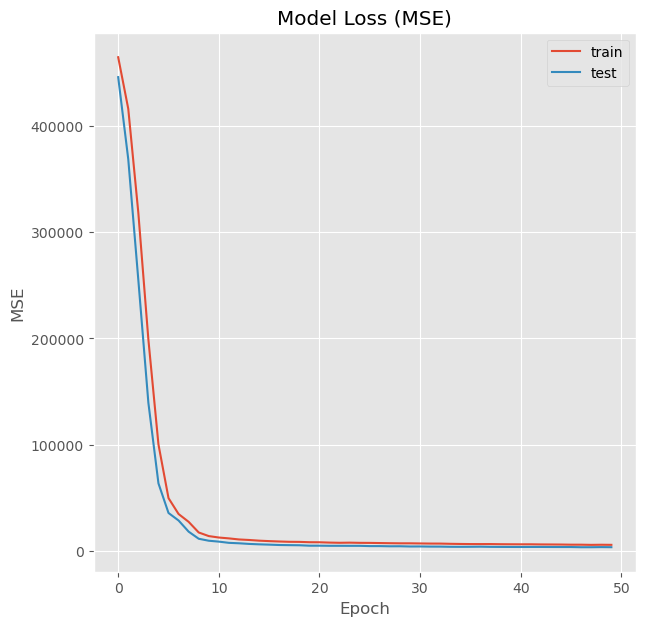

Evaluating model on test dataset
469/469 [==============================] - 0s 720us/step - loss: 3212.2346
Test data loss: 3212.234619140625


INFO:tensorflow:Assets written to: ./saved_models/LSTM_regression_loss3212.234619140625_epochs50_20210426/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_regression_loss3212.234619140625_epochs50_20210426/assets


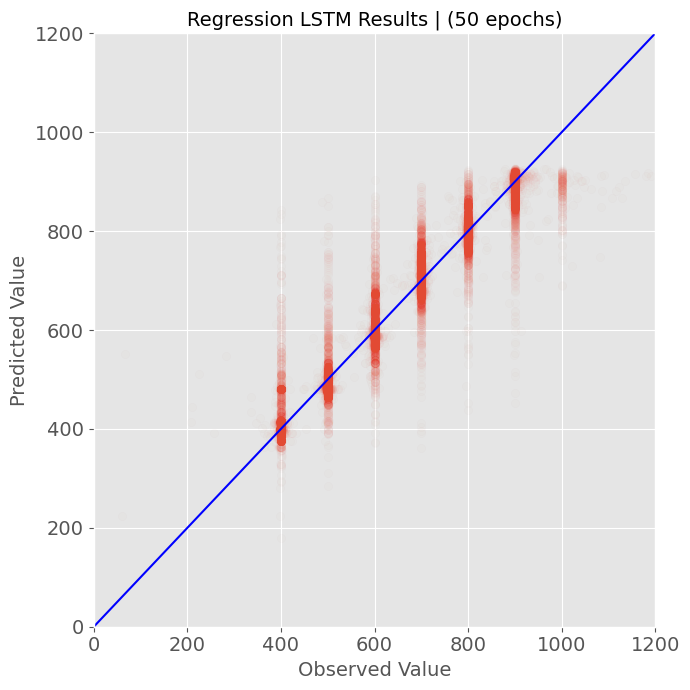

In [54]:
# use RegressionLSTM
# predict p-wave arrival time
model_rp = RegressionLSTM(envelopes_path,label_csv_path,'p_arrival_sample')
model_rp.train_test_split(test_size=0.25,random_state=44)
model_rp.LSTM_fit(epochs=50,batch_size=64)
model_rp.LSTM_evaluate()

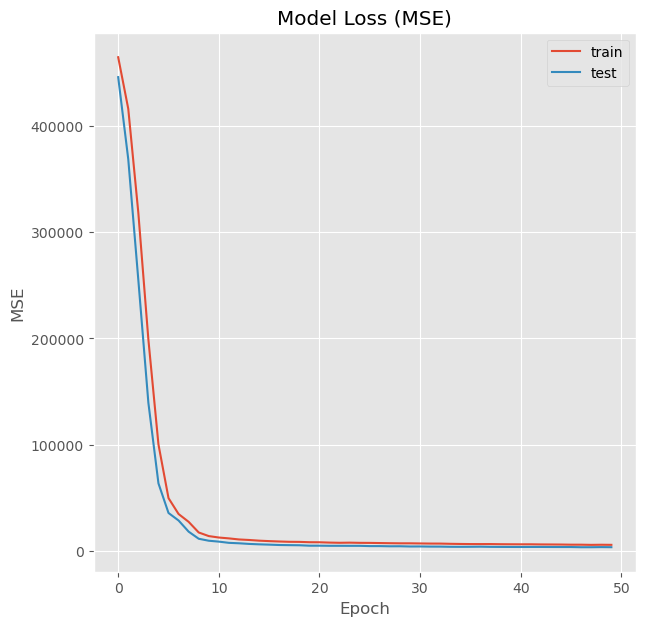

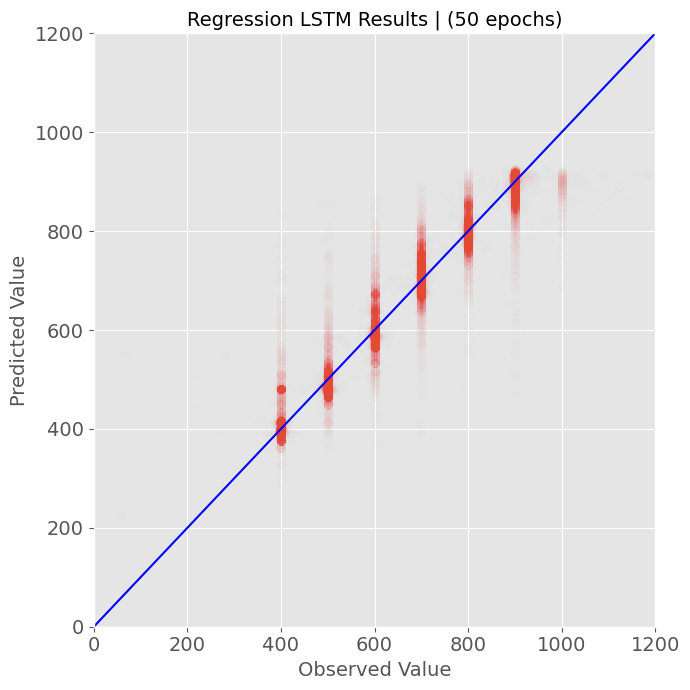

The baseline mse for p-wave time prediction is 30772.70156806433 

The mse of the LSTM regression for p-wave time prediction is 3212.234619140625 



In [62]:
# plot train/test accuracy history
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(model_rp.history.history['loss'])
ax.plot(model_rp.history.history['val_loss'])
ax.set_title('Model Loss (MSE)')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train','test'])
plt.savefig('model_loss.png')
plt.show()

# plot y true vs. y predicted
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(model_rp.y_test,model_rp.y_pred,alpha=0.005)
point1 = [0,0]
point2 = [1200,1200]
xvalues = [point1[0], point2[0]]
yvalues = [point1[1], point2[1]]
ax.plot(xvalues,yvalues,color='blue')
ax.set_ylabel('Predicted Value',fontsize=14)
ax.set_xlabel('Observed Value',fontsize=14)
ax.set_title(f'Regression LSTM Results | ({model_rp.epochs} epochs)',fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,1200])
ax.set_ylim([0,1200])
plt.tight_layout()
plt.savefig('true_vs_predicted.png')
plt.show()

# baseline for magnitude regression
baseline_residuals = model_rp.y_test - np.mean(model_rp.y_test)
baseline_mse = np.mean(baseline_residuals**2)
baseline_mse
print(f'The baseline mse for p-wave time prediction is {baseline_mse} \n')

# print mse for the regression model
print(f'The mse of the LSTM regression for p-wave time prediction is {model_rp.test_loss} \n')

/Users/kaelynnrose/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


60000
60000
Epoch 1/50
563/563 [==============================] - 4s 3ms/step - loss: 2153249.5089 - val_loss: 2052073.0000


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 2/50
563/563 [==============================] - 1s 2ms/step - loss: 2007595.6148 - val_loss: 1778552.6250


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 3/50
563/563 [==============================] - 1s 2ms/step - loss: 1678182.3551 - val_loss: 1379753.6250


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 4/50
563/563 [==============================] - 1s 2ms/step - loss: 1283580.2553 - val_loss: 957509.0625


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 5/50
563/563 [==============================] - 1s 2ms/step - loss: 884530.2234 - val_loss: 618876.7500


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 6/50
563/563 [==============================] - 1s 2ms/step - loss: 570358.7662 - val_loss: 416823.4062


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 7/50
563/563 [==============================] - 1s 2ms/step - loss: 385166.7599 - val_loss: 284810.6250


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 8/50
563/563 [==============================] - 1s 2ms/step - loss: 276200.2945 - val_loss: 205977.3438


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 9/50
563/563 [==============================] - 1s 2ms/step - loss: 206070.2660 - val_loss: 160789.2344


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 10/50
563/563 [==============================] - 1s 2ms/step - loss: 164065.9966 - val_loss: 133268.0312


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 11/50
563/563 [==============================] - 1s 2ms/step - loss: 141292.5689 - val_loss: 115916.2422


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 12/50
563/563 [==============================] - 1s 2ms/step - loss: 127922.0984 - val_loss: 102655.0859


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 13/50
563/563 [==============================] - 1s 2ms/step - loss: 115856.1028 - val_loss: 91714.3359


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 14/50
563/563 [==============================] - 1s 2ms/step - loss: 102791.0931 - val_loss: 83110.8828


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 15/50
563/563 [==============================] - 1s 2ms/step - loss: 94426.8917 - val_loss: 75550.2422


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 16/50
563/563 [==============================] - 1s 2ms/step - loss: 90678.0244 - val_loss: 68900.2578


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 17/50
563/563 [==============================] - 1s 2ms/step - loss: 82050.4636 - val_loss: 64825.2070


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 18/50
563/563 [==============================] - 1s 2ms/step - loss: 78376.8274 - val_loss: 60690.8438


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 19/50
563/563 [==============================] - 1s 2ms/step - loss: 74855.9806 - val_loss: 58810.3633


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 20/50
563/563 [==============================] - 1s 2ms/step - loss: 70839.9252 - val_loss: 56913.2930


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 21/50
563/563 [==============================] - 1s 2ms/step - loss: 69044.0539 - val_loss: 56434.0938


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 22/50
563/563 [==============================] - 1s 2ms/step - loss: 66119.5025 - val_loss: 53941.5039


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 23/50
563/563 [==============================] - 1s 2ms/step - loss: 62630.6298 - val_loss: 52613.3320


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 24/50
563/563 [==============================] - 1s 2ms/step - loss: 61130.4217 - val_loss: 52758.0156


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 25/50
563/563 [==============================] - 1s 2ms/step - loss: 64796.0015 - val_loss: 51857.1250


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 26/50
563/563 [==============================] - 1s 2ms/step - loss: 60555.4135 - val_loss: 50904.0781


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 27/50
563/563 [==============================] - 1s 2ms/step - loss: 62236.7449 - val_loss: 50155.6797


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 28/50
563/563 [==============================] - 1s 2ms/step - loss: 60321.3867 - val_loss: 49658.0000


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 29/50
563/563 [==============================] - 1s 2ms/step - loss: 60156.4300 - val_loss: 48908.9023


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 30/50
563/563 [==============================] - 1s 2ms/step - loss: 54625.4767 - val_loss: 47646.7617


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 31/50
563/563 [==============================] - 1s 2ms/step - loss: 57308.8881 - val_loss: 45704.7773


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 32/50
563/563 [==============================] - 1s 2ms/step - loss: 52963.0506 - val_loss: 46315.0820


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 33/50
563/563 [==============================] - 1s 2ms/step - loss: 53804.4903 - val_loss: 45200.3945


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 34/50
563/563 [==============================] - 1s 2ms/step - loss: 53728.8175 - val_loss: 45046.7148


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 35/50
563/563 [==============================] - 1s 2ms/step - loss: 55352.6358 - val_loss: 43910.6562


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 36/50
563/563 [==============================] - 1s 2ms/step - loss: 49247.2159 - val_loss: 44032.4141


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 37/50
563/563 [==============================] - 1s 2ms/step - loss: 49604.2633 - val_loss: 43919.9219


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 38/50
563/563 [==============================] - 1s 2ms/step - loss: 51746.6731 - val_loss: 43397.1797


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 39/50
563/563 [==============================] - 1s 2ms/step - loss: 50413.5444 - val_loss: 43274.1797


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 40/50
563/563 [==============================] - 1s 2ms/step - loss: 46788.9034 - val_loss: 42039.5469


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 41/50
563/563 [==============================] - 1s 2ms/step - loss: 49180.8941 - val_loss: 42554.4219


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 42/50
563/563 [==============================] - 1s 2ms/step - loss: 49748.3805 - val_loss: 42920.8789


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 43/50
563/563 [==============================] - 1s 2ms/step - loss: 46100.5975 - val_loss: 42034.6016


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 44/50
563/563 [==============================] - 1s 2ms/step - loss: 47654.9334 - val_loss: 41169.4648


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 45/50
563/563 [==============================] - 1s 2ms/step - loss: 47821.2945 - val_loss: 41048.9414


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 46/50
563/563 [==============================] - 1s 2ms/step - loss: 45993.5072 - val_loss: 40681.4102


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 47/50
563/563 [==============================] - 1s 2ms/step - loss: 46060.3103 - val_loss: 40832.7852


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 48/50
563/563 [==============================] - 1s 2ms/step - loss: 44871.9494 - val_loss: 39357.4922


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 49/50
563/563 [==============================] - 1s 2ms/step - loss: 45920.9939 - val_loss: 39320.3359


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


Epoch 50/50
563/563 [==============================] - 1s 2ms/step - loss: 41944.7552 - val_loss: 39751.0312


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619473903/assets


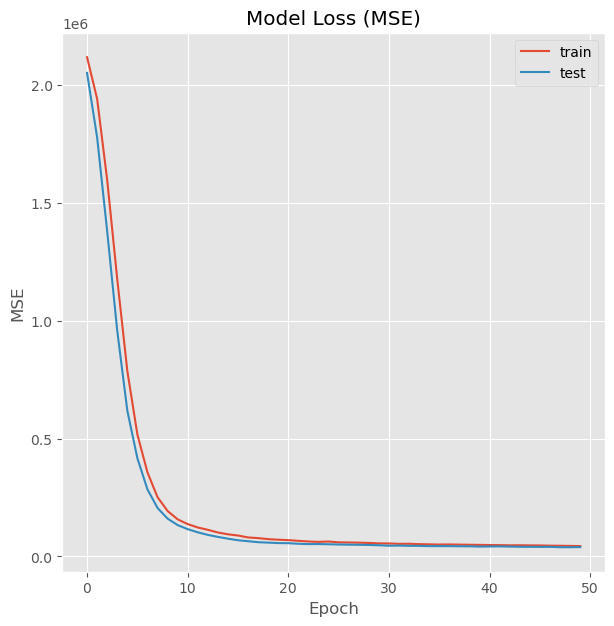

Evaluating model on test dataset
469/469 [==============================] - 0s 733us/step - loss: 42508.5781
Test data loss: 42508.578125


INFO:tensorflow:Assets written to: ./saved_models/LSTM_regression_loss42508.578125_epochs50_20210426/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_regression_loss42508.578125_epochs50_20210426/assets


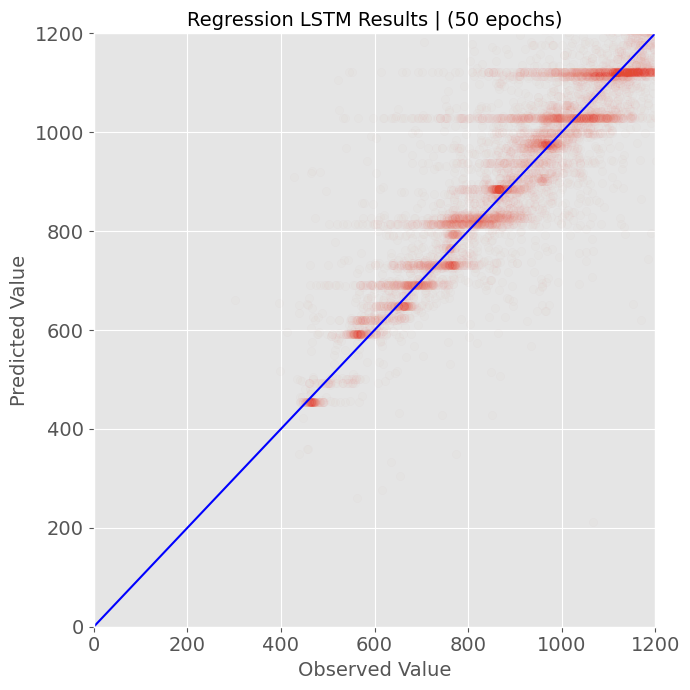

In [56]:
# use RegressionLSTM
# predict s-wave arrival time
model_rs = RegressionLSTM(envelopes_path,label_csv_path,'s_arrival_sample')
model_rs.train_test_split(test_size=0.25,random_state=44)
model_rs.LSTM_fit(epochs=50,batch_size=64)
model_rs.LSTM_evaluate()

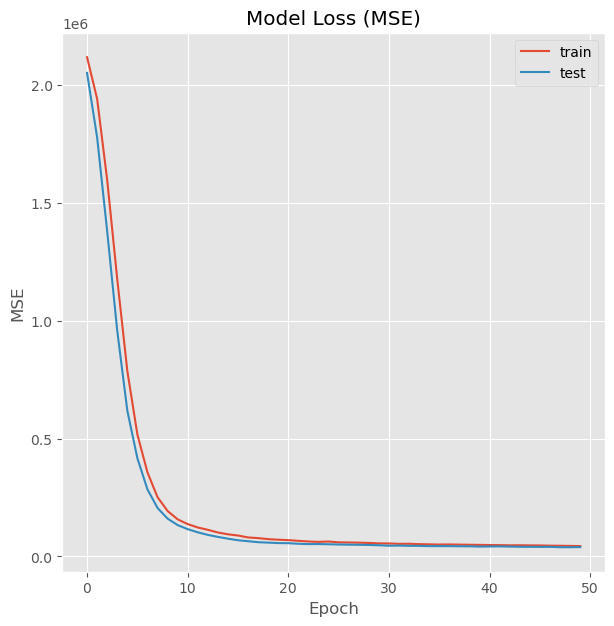

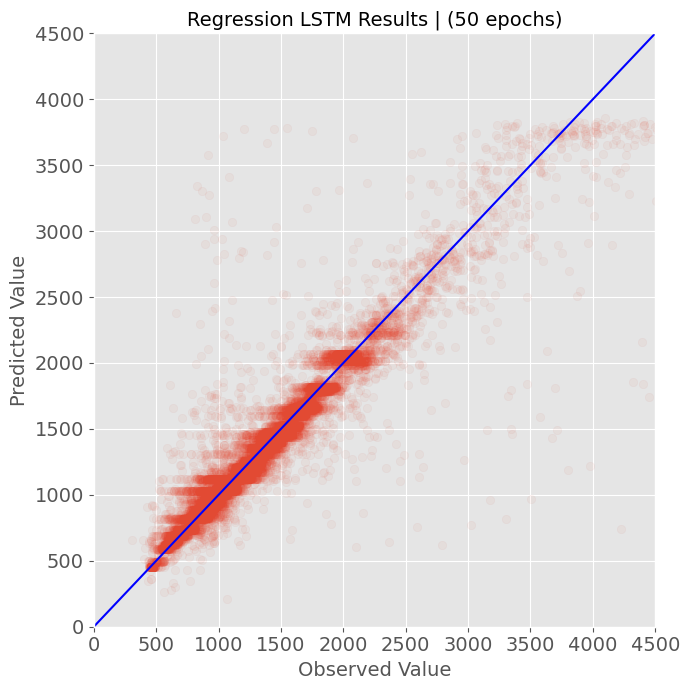

The baseline mse for s-wave time prediction is 366620.90600771894 

The mse of the LSTM regression for s-wave time prediction is 42508.578125 



In [63]:
# plot train/test accuracy history
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(model_rs.history.history['loss'])
ax.plot(model_rs.history.history['val_loss'])
ax.set_title('Model Loss (MSE)')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train','test'])
plt.savefig('model_loss.png')
plt.show()

# plot y true vs. y predicted
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(model_rs.y_test,model_rs.y_pred,alpha=0.05)
point1 = [0,0]
point2 = [4500,4500]
xvalues = [point1[0], point2[0]]
yvalues = [point1[1], point2[1]]
ax.plot(xvalues,yvalues,color='blue')
ax.set_ylabel('Predicted Value',fontsize=14)
ax.set_xlabel('Observed Value',fontsize=14)
ax.set_title(f'Regression LSTM Results | ({model_rs.epochs} epochs)',fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,4500])
ax.set_ylim([0,4500])
plt.tight_layout()
plt.savefig('true_vs_predicted.png')
plt.show()

# baseline for magnitude regression
baseline_residuals = model_rs.y_test - np.mean(model_rs.y_test)
baseline_mse = np.mean(baseline_residuals**2)
baseline_mse
print(f'The baseline mse for s-wave time prediction is {baseline_mse} \n')

# print mse for the regression model
print(f'The mse of the LSTM regression for s-wave time prediction is {model_rs.test_loss} \n')

/Users/kaelynnrose/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


60000
60000
Epoch 1/50
563/563 [==============================] - 4s 3ms/step - loss: 2.5249 - val_loss: 0.7943


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 2/50
563/563 [==============================] - 1s 2ms/step - loss: 0.7413 - val_loss: 0.5868


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 3/50
563/563 [==============================] - 1s 2ms/step - loss: 0.6005 - val_loss: 0.5525


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 4/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5696 - val_loss: 0.5294


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 5/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5572 - val_loss: 0.5160


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 6/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5344 - val_loss: 0.5098


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 7/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5345 - val_loss: 0.4983


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 8/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5129 - val_loss: 0.4996


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 9/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5133 - val_loss: 0.4982


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 10/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5111 - val_loss: 0.5108


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 11/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5186 - val_loss: 0.4978


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 12/50
563/563 [==============================] - 1s 2ms/step - loss: 0.5047 - val_loss: 0.4870


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 13/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4945 - val_loss: 0.4858


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 14/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4900 - val_loss: 0.4818


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 15/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4836 - val_loss: 0.4756


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 16/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4891 - val_loss: 0.4746


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 17/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4849 - val_loss: 0.4723


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 18/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4814 - val_loss: 0.4590


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 19/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4738 - val_loss: 0.4595


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 20/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4672 - val_loss: 0.4531


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 21/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4638 - val_loss: 0.4460


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 22/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4594 - val_loss: 0.4575


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 23/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4667 - val_loss: 0.4562


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 24/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4608 - val_loss: 0.4494


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 25/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4706 - val_loss: 0.4462


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 26/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4576 - val_loss: 0.4420


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 27/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4423 - val_loss: 0.4376


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 28/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4475 - val_loss: 0.4362


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 29/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4484 - val_loss: 0.4330


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 30/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4377 - val_loss: 0.4324


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 31/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4347 - val_loss: 0.4139


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 32/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4299 - val_loss: 0.4167


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 33/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4170 - val_loss: 0.4210


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 34/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4237 - val_loss: 0.4166


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 35/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4181 - val_loss: 0.4241


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 36/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4191 - val_loss: 0.4167


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 37/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4230 - val_loss: 0.4393


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 38/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.4150


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 39/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4271 - val_loss: 0.4138


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 40/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4362 - val_loss: 0.4125


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 41/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4195 - val_loss: 0.4103


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 42/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4207 - val_loss: 0.4013


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 43/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4256 - val_loss: 0.4121


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 44/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4198 - val_loss: 0.4105


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 45/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4131 - val_loss: 0.4084


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 46/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4065 - val_loss: 0.4014


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 47/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4044 - val_loss: 0.4022


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 48/50
563/563 [==============================] - 1s 2ms/step - loss: 0.4071 - val_loss: 0.4090


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 49/50
563/563 [==============================] - 1s 2ms/step - loss: 0.3979 - val_loss: 0.3988


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


Epoch 50/50
563/563 [==============================] - 1s 2ms/step - loss: 0.3884 - val_loss: 0.3865


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_100000_dataset_regression_epochs50_20210426Apr041619474718/assets


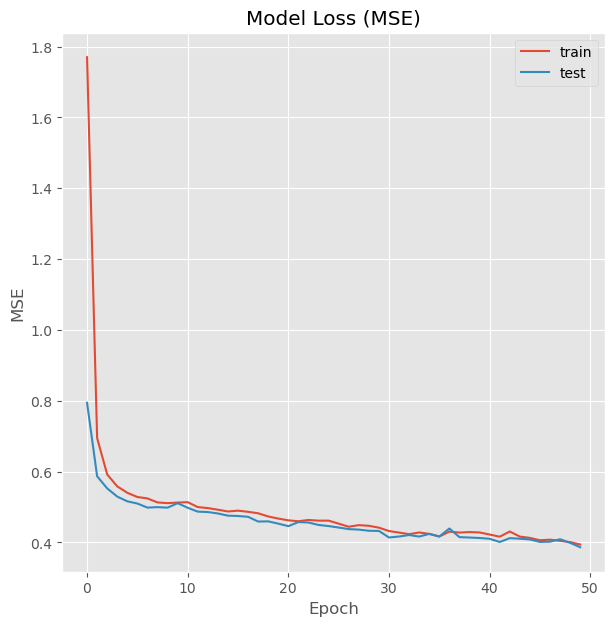

Evaluating model on test dataset
469/469 [==============================] - 0s 724us/step - loss: 0.3874
Test data loss: 0.38736453652381897


INFO:tensorflow:Assets written to: ./saved_models/LSTM_regression_loss0.38736453652381897_epochs50_20210426/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_regression_loss0.38736453652381897_epochs50_20210426/assets


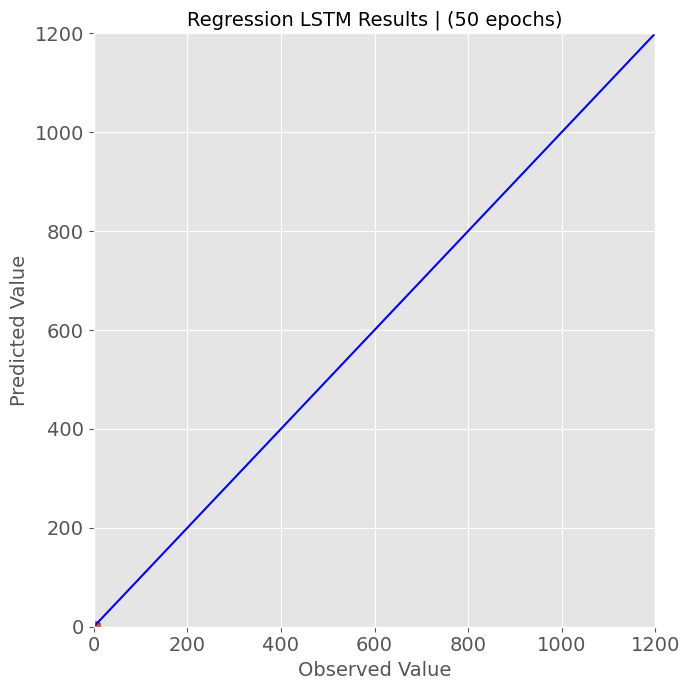

In [58]:
# use RegressionLSTM
# predict earthquake magnitude
model_rm = RegressionLSTM(envelopes_path,label_csv_path,'source_magnitude')
model_rm.train_test_split(test_size=0.25,random_state=44)
model_rm.LSTM_fit(epochs=50,batch_size=64)
model_rm.LSTM_evaluate()

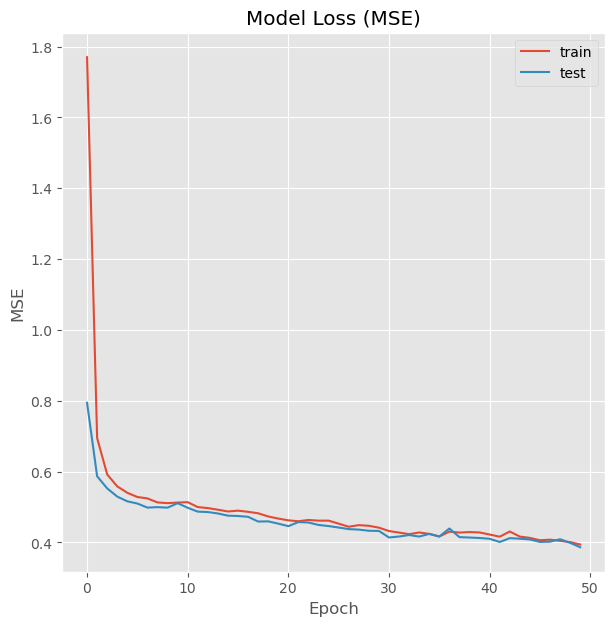

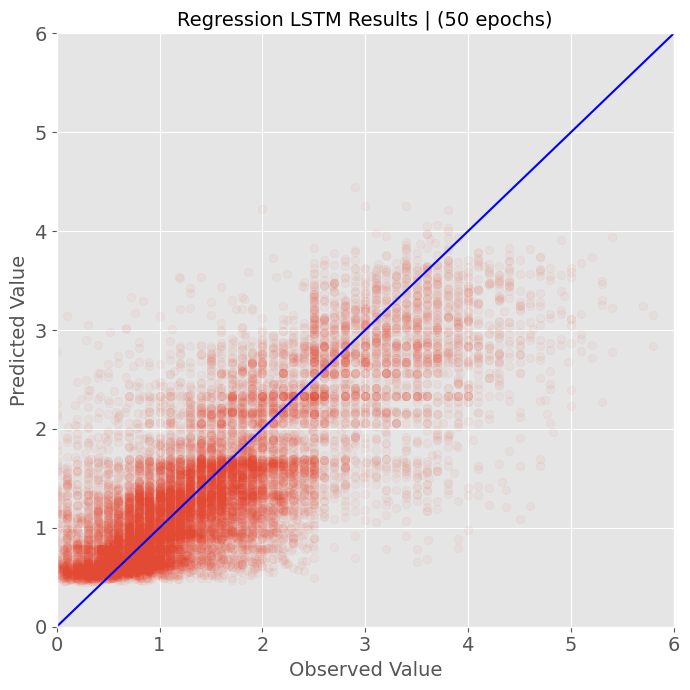

The baseline mse for earthquake magnitude is 0.9567373607639829 

The mse of the LSTM regression for earthquake magnitude is 0.38736453652381897 



In [64]:
# plot train/test accuracy history
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(model_rm.history.history['loss'])
ax.plot(model_rm.history.history['val_loss'])
ax.set_title('Model Loss (MSE)')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train','test'])
plt.savefig('model_loss.png')
plt.show()

# plot y true vs. y predicted
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(model_rm.y_test,model_rm.y_pred,alpha=0.05)
point1 = [0,0]
point2 = [7,7]
xvalues = [point1[0], point2[0]]
yvalues = [point1[1], point2[1]]
ax.plot(xvalues,yvalues,color='blue')
ax.set_ylabel('Predicted Value',fontsize=14)
ax.set_xlabel('Observed Value',fontsize=14)
ax.set_title(f'Regression LSTM Results | ({model_rm.epochs} epochs)',fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,6])
ax.set_ylim([0,6])
plt.tight_layout()
plt.savefig('true_vs_predicted.png')
plt.show()

# baseline for magnitude regression
baseline_residuals = model_rm.y_test - np.mean(model_rm.y_test)
baseline_mse = np.mean(baseline_residuals**2)
baseline_mse
print(f'The baseline mse for earthquake magnitude is {baseline_mse} \n')

# print mse for the regression model
print(f'The mse of the LSTM regression for earthquake magnitude is {model_rm.test_loss} \n')